# Multiclass Classification

## gradient vanishing (기울기 소실)
밑바닥부터 시작하는 딥러닝(204p)<br>
활성함수로 ReLU 사용

## Cross Entropy Loss
https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html <br>
The input is expected to contain the unnormalized logits for each class (which do not need to be positive or sum to 1, in general).<br>
torch CELoss 주의사항 : 모델 forward 의 마지막 출력층은 linear 형태야야 한다. (the unnormalized logits := nn.Softmax() 없어야한다.)


In [12]:
import torch.nn as nn

class Classifier(nn.Module):
  def __init__(self):
    super(Classifier, self).__init__()
    self.fc1 = nn.Linear(in_features=2, out_features=16)
    self.fc_act1 = nn.ReLU()
    self.fc2 = nn.Linear(in_features=16, out_features=32)
    self.fc_act2 = nn.ReLU()
    self.fc3 = nn.Linear(in_features=32, out_features=4)
    # self.softmax = nn.Softmax()
    

  def forward(self, x):
    x = self.fc1(x)
    x = self.fc_act1(x)
    x = self.fc2(x)
    x = self.fc_act2(x)
    x = self.fc3(x)
    # x = self.softmax(x)

    return x

In [13]:
from sklearn.datasets import make_blobs
import torch
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt


def get_dataset(N_SAMPLES, BATCH_SIZE, centers):
  X_, y_ = make_blobs(n_samples=N_SAMPLES, centers=centers, n_features=2, cluster_std=0.5, random_state=0)
  dataset = TensorDataset(torch.FloatTensor(X_), torch.LongTensor(y_))
  data_loader = DataLoader(dataset, batch_size=BATCH_SIZE)
  return data_loader, X_, y_

def get_device():
  if torch.cuda.is_available():DEVICE = 'cuda'
  elif torch.backends.mps.is_available(): DEVICE = 'mps'
  else: DEVICE = 'cpu'
  return DEVICE

def train(data_loader, N_SAMPLES, model, loss_function, optimizer, DEVICE):
  epoch_loss, n_corrects = 0., 0
  for X, y in data_loader:
    X, y = X.to(DEVICE), y.to(DEVICE)
    pred = model.forward(X)
    loss = loss_function(pred, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    epoch_loss += loss.item() * len(X)
    pred = torch.argmax(pred, dim=1)
    n_corrects += (pred == y).sum().item()
  epoch_loss /= N_SAMPLES
  epoch_acc = n_corrects / N_SAMPLES

  return epoch_loss, epoch_acc

def vis_losses_accs(losses, accs, X_, y_):
  fig, axes = plt.subplots(3, 1, figsize=(7, 21))
  axes[0].scatter(X_[:,0], X_[:,1], c=y_)
  axes[1].plot(losses)
  axes[1].set_ylabel('BCELoss')
  axes[2].plot(accs)
  axes[2].set_ylabel('Accuracy')
  axes[2].set_xlabel('Epoch')



Loss : 0.0008250268153400006, Accuracy : 1.0



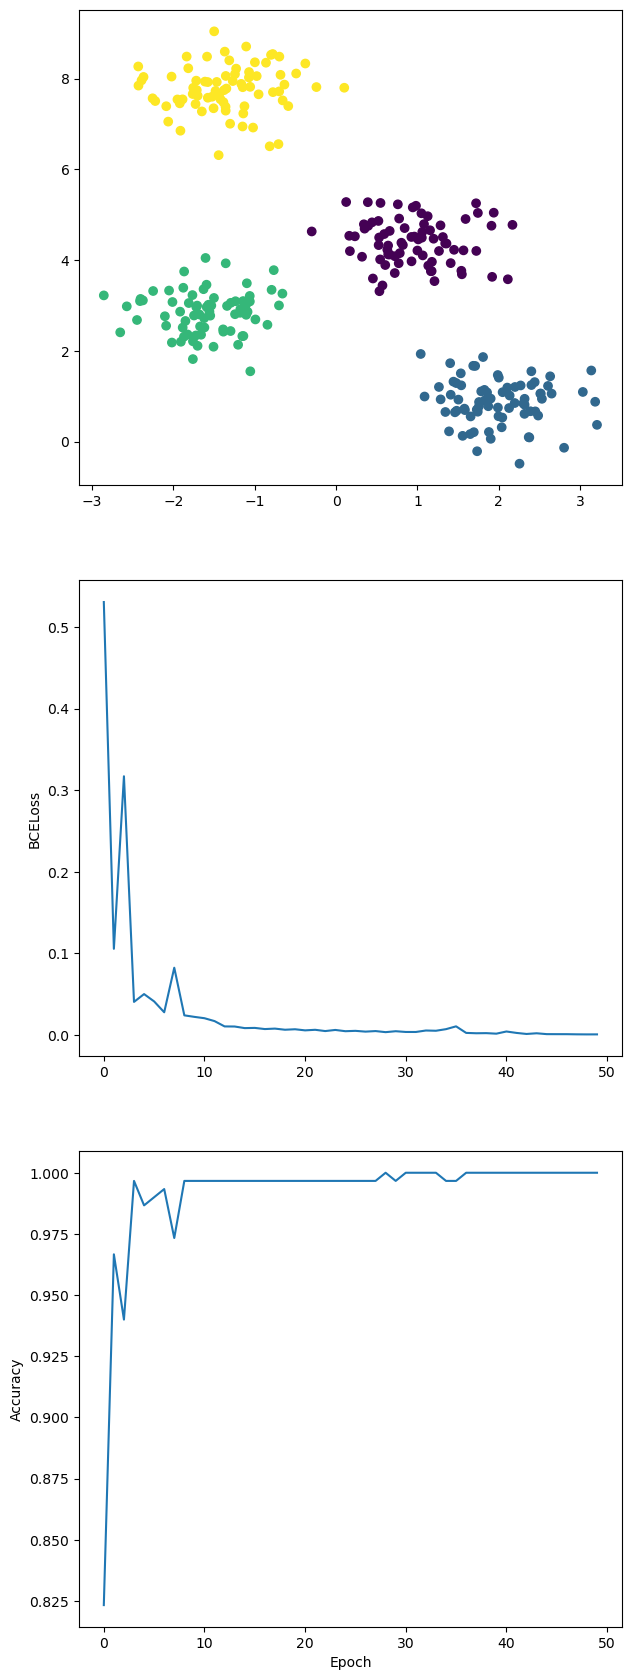

In [14]:
from torch.optim import SGD

N_SAMPLES = 300
BATCH_SIZE = 8
EPOCHS = 50
LR = 0.2
centers = 4

data_loader, X_, y_ = get_dataset(N_SAMPLES, BATCH_SIZE, centers)
DEVICE = get_device()


model = Classifier().to(DEVICE)
loss_function = nn.CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=LR)

losses, accs = [], []
for epoch in range(EPOCHS):
  epoch_loss, epoch_acc = train(data_loader, N_SAMPLES, model, loss_function, optimizer, DEVICE)

  losses.append(epoch_loss)
  accs.append(epoch_acc)

vis_losses_accs(losses, accs, X_, y_)
print(f'Loss : {losses[-1]}, Accuracy : {accs[-1]}\n')

# MNIST

In [ ]:
import torch.nn as nn

class MnistClassifier(nn.Module):
  def __init__(self):
    super(MnistClassifier, self).__init__()
    self.fc1 = nn.Linear(in_features=784, out_features=16)
    self.fc_act1 = nn.ReLU()
    self.fc2 = nn.Linear(in_features=16, out_features=32)
    self.fc_act2 = nn.ReLU()
    self.fc3 = nn.Linear(in_features=32, out_features=10)

  def forward(self, x):
    x = self.fc1(x)
    x = self.fc_act1(x)
    x = self.fc2(x)
    x = self.fc_act2(x)
    x = self.fc3(x)

    return x

In [ ]:
import torch
from sklearn.datasets import make_blobs
from torch.utils.data import TensorDataset, DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


def get_dataset():
  dataset = MNIST(root='data', train=True, download=True, transform=ToTensor())
  N_DATA = len(dataset)
  data_loader = DataLoader(dataset, batch_size=BATCH_SIZE)
  return data_loader, N_DATA

def get_device():
  if torch.cuda.is_available():DEVICE = 'cuda'
  elif torch.backends.mps.is_available(): DEVICE = 'mps'
  else: DEVICE = 'cpu'
  return DEVICE

def train(data_loader, model, loss_function, BATCH_SIZE, N_DATA, optimizer, DEVICE):
  epoch_loss, n_corrects = 0., 0
  for X, y in data_loader:
    X, y = X.to(DEVICE), y.to(DEVICE)
    X = X.reshape(BATCH_SIZE, -1)

    pred = model.forward(X)
    loss = loss_function(pred, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    epoch_loss += loss.item() * len(X)
    pred = torch.argmax(pred, dim=1)
    n_corrects += (pred == y).sum().item()

  epoch_loss /= N_DATA
  epoch_acc = n_corrects / N_DATA

  return epoch_loss, epoch_acc

def vis_losses_accs(losses, accs):
  fig, axes = plt.subplots(2, 1, figsize=(7, 14))
  axes[0].plot(losses)
  axes[0].set_ylabel('BCELoss')
  axes[1].plot(accs)
  axes[1].set_ylabel('Accuracy')
  axes[1].set_xlabel('Epoch')


In [ ]:
from torch.optim import SGD
from tqdm import tqdm

BATCH_SIZE = 32
EPOCHS = 50
LR = 0.01
centers = 4

pbar = tqdm(range(EPOCHS))

data_loader, N_DATA = get_dataset()
DEVICE = get_device()

model = MnistClassifier().to(DEVICE)
loss_function = nn.CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=LR)

losses, accs = [], []
for epoch in pbar:
  epoch_loss, epoch_acc = train(data_loader, model, loss_function, BATCH_SIZE, N_DATA, optimizer, DEVICE)
  losses.append(epoch_loss)
  accs.append(epoch_acc)
pbar.close()

vis_losses_accs(losses, accs)
print(f'Loss : {losses[-1]}, Accuracy : {accs[-1]}\n')
